In [23]:
from lstm_creator import createLstmModelFromDatasets, scaleData, preprocessData
from predict_next_value import predict_next, load_x_from_file
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
# register_matplotlib_converters()

In [24]:
lookback_length = 90
sample_every_x = 60

paths = ["../../../data/MorningTest.csv", "../../../data/MorningTest5.csv", "../../../data/MorningTest6.csv", "../../../data/MorningTest10.csv"]
model = createLstmModelFromDatasets(paths, lookback_length, sample_every_x)

# live_data = load_x_from_file("../../../data/MorningTest2.csv", lookback_length)
# next_value = predict_next(model, live_data)
# print(next_value)

Epoch 1/6
17/17 [==============================] - 4s 46ms/step - loss: 0.0801
Epoch 2/6
17/17 [==============================] - 1s 44ms/step - loss: 0.0110
Epoch 3/6
17/17 [==============================] - 1s 42ms/step - loss: 0.0063
Epoch 4/6
17/17 [==============================] - 1s 42ms/step - loss: 0.0055
Epoch 5/6
17/17 [==============================] - 1s 43ms/step - loss: 0.0042
Epoch 6/6
17/17 [==============================] - 1s 51ms/step - loss: 0.0044
Epoch 1/6
6/6 [==============================] - 0s 52ms/step - loss: 0.0049
Epoch 2/6
6/6 [==============================] - 0s 52ms/step - loss: 0.0058
Epoch 3/6
6/6 [==============================] - 0s 52ms/step - loss: 0.0056
Epoch 4/6
6/6 [==============================] - 0s 53ms/step - loss: 0.0031
Epoch 5/6
6/6 [==============================] - 0s 50ms/step - loss: 0.0024
Epoch 6/6
6/6 [==============================] - 0s 53ms/step - loss: 0.0021
Epoch 1/6
16/16 [==============================] - 1s 52ms/step 

# Testing

In [29]:
def evaluate_model(real_data, predicted_data, inherent_loss=2):
    slope_to_buy_at = .5

    real_data = real_data.reshape(len(real_data))
    predicted_data = predicted_data.reshape(len(predicted_data))

    real_diff = np.diff(real_data)
    predicted_diff = np.diff(predicted_data)

    correct_slopes = 0
    profit = 0
    for i in range(len(real_data)-1):
        if np.sign(real_diff[i]) == np.sign(predicted_diff[i]):
            correct_slopes = correct_slopes + 1
            
            # If we have a positive slope calculate profit
            if real_diff[i] > slope_to_buy_at:
                # we subtract inherent_loss due to the limit market mechanics
                revenue = (real_data[i+1] - real_data[i]) - inherent_loss
                if revenue > 0:
                    print(f"Found a profit where current value is {real_data[i+1]} last was {real_data[i]} net {revenue}")
                    profit = profit + revenue

        else:
            # We guessed wrong
            if predicted_diff[i] > slope_to_buy_at:
                # we would have bought
                revenue = (real_data[i+1] - real_data[i]) - inherent_loss
                print(f"Selling at a loss of {revenue}")
                profit = profit + revenue

    return (correct_slopes, profit)

def eval_model_on_dataset(actual, prediction, subsampling, inherent_loss):
    # Determine the number of cases in which we predicted a correct increase
    correct_slopes, profit = evaluate_model(actual, prediction, inherent_loss)

    print(f"Found {correct_slopes} out of {len(actual)-1}")
    precent_success = (correct_slopes/(len(actual)-1)) * 100
    print(f"{precent_success}%")
    print("Profit:", profit)
    return profit

In [30]:
def testModel(model, length, path_to_testing_dataset, quiet=False):

    datasets, scaler = scaleData([path_to_testing_dataset], 1)

    hist, actual = preprocessData(datasets[0], length)

    pred = model.predict(hist)

    pred_transformed = scaler.inverse_transform(pred)
    actual_transformed = scaler.inverse_transform(actual)

    if not quiet:
        plt.figure(figsize=(12,8))
        plt.plot(actual_transformed, color='blue', label='Real')
        plt.plot(pred_transformed, color='red', label='Prediction')
        plt.title('ETH Price Prediction')
        plt.legend()
        plt.show()

    return eval_model_on_dataset(actual=actual_transformed, prediction=pred_transformed, subsampling=1, inherent_loss=1.5)

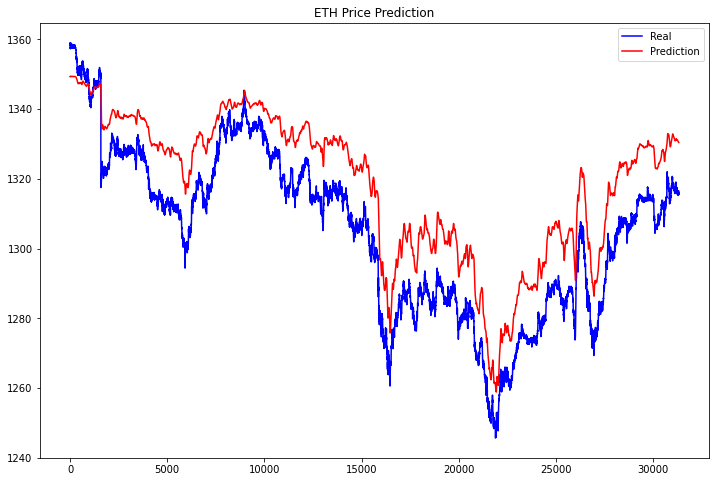

Found a profit where current value is 1310.23 last was 1308.555 net 0.17499999999995453
Found a profit where current value is 1316.355 last was 1314.219701 net 0.6352990000000318
Found a profit where current value is 1333.567478 last was 1331.601167 net 0.4663109999999051
Found a profit where current value is 1263.55 last was 1261.651435 net 0.3985649999999623
Found a profit where current value is 1292.94 last was 1291.430021 net 0.009979000000157612
Found a profit where current value is 1305.503751 last was 1302.862563 net 1.1411880000000565
Found a profit where current value is 1307.301881 last was 1305.481157 net 0.3207240000001548
Found a profit where current value is 1309.21553 last was 1307.009637 net 0.7058929999998327
Found a profit where current value is 1319.418665 last was 1317.867649 net 0.05101599999989048
Found a profit where current value is 1319.535 last was 1317.898931 net 0.1360690000001341
Found 15873 out of 31309
50.69788239803251%
Profit: 4.04004400000008


4.04004400000008

In [40]:
testModel(model, lookback_length, "../../../data/MorningTest10.csv")